#### 定量的マクロ経済学と数値計算 第3章 動的計画法
①ロビンソン・クルーソーとベルマン方程式: メインファイル

In [5]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import fmin
import matplotlib.pyplot as plt
import japanize_matplotlib
from CRRA import CRRA
from BellmanEq import BellmanEq
import time

In [2]:
#カリブレーション
class Model():
    """
    ロビンソン・クルーソーモデルを解くためのパラメータを含む class を定義する。
    """
    def __init__(self,
        beta = 0.96, # 割引因子
        gamma = 1.0, # 異時点間の代替弾力性の逆数
        alpha = 0.4, # 資本分配率 
        delta = 1.0, # 固定資本減耗
        nk = 11,     # 資本のグリッド数
        kmax = 1.0,  # 資本グリッドの最大値
        kmin = 0.05, # 資本グリッドの最小値
        TT = 10,     # 生存期間(助けが来るまでの期間)
        ): 
        
        self.beta, self.gamma, self.alpha = beta, gamma, alpha 
        self.delta, self.TT, self.nk = delta, TT, nk 
        self.kmax, self.kmin = kmax, kmin 
        self.kgrid = np.linspace(kmin,kmax,nk) # 資本のグリッド

In [3]:
m = Model()
CRRA_vec =  np.vectorize(CRRA) # CRRA関数をベクトル化する
vfcn = np.empty((m.nk,m.TT)) # 価値関数
pfcn = np.empty((m.nk,m.TT)) # 政策関数
cfcn = np.empty((m.nk,m.TT)) # 消費関数

#計算開始
print(f"Solve Robinson Crusoe Economy with {m.TT} Periods")

#最終期(全てを消費) 
# ※pythonはzero-based indexing なので 最後の要素のインデックスはTT-1である。
pfcn[:,m.TT-1] = 0
cfcn[:,m.TT-1] = m.kgrid ** m.alpha
vfcn[:,m.TT-1] = CRRA_vec(m,cfcn[:,m.TT-1])

#メインループ
for t in reversed(range(m.TT-1)):
    
    print(f"period {t+1}:")
    vnext = interp1d(m.kgrid, vfcn[:,t+1], kind="cubic",fill_value='extrapolate') 

    for i in range(m.nk):

        capital = m.kgrid[i]
        Bellman = lambda x: BellmanEq(m,capital,x,vnext) #kprime 以外を固定して kprimeの関数にしている
        pfcn[i,t] = fmin(Bellman,x0=0.01,disp=False)
        vfcn[i,t] = -Bellman(pfcn[i,t]) #fminは最小値を探す関数なので符号を反転させる
        cfcn[i,t] = (capital ** m.alpha) - pfcn[i,t]


#計算結果をコマンドウィンドウに表示
print("-+- PARAMETER VALUES -+-")
print(f"beta={m.beta}, gamma={m.gamma}, alpha={m.alpha}")
print(f"kmin={m.kmin}, kmax={m.kmax}, grid={m.nk}")

#解析的解
p_true = np.empty((m.nk,m.TT))
for t in range(m.TT):
    for i in range(m.nk):

        p_true[i,t] = m.alpha * m.beta * ((1- (m.alpha*m.beta)**(m.TT-t-1)) / (1- (m.alpha*m.beta)**(m.TT-t))) * ((m.kgrid[i] ** m.alpha))



Solve Robinson Crusoe Economy with 10 Periods
period 9:
period 8:
period 7:
period 6:
period 5:
period 4:
period 3:
period 2:
period 1:
-+- PARAMETER VALUES -+-
beta=0.96, gamma=1.0, alpha=0.4
kmin=0.05, kmax=1.0, grid=11


### 図を描く

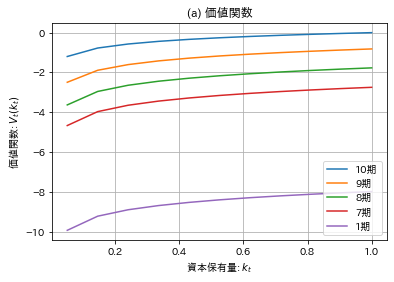

In [4]:
fig, ax = plt.subplots()
ax.plot(m.kgrid,vfcn[:,m.TT-1],label="10期")
ax.plot(m.kgrid,vfcn[:,8],label="9期")
ax.plot(m.kgrid,vfcn[:,7],label="8期")
ax.plot(m.kgrid,vfcn[:,6],label="7期")
ax.plot(m.kgrid,vfcn[:,0],label="1期")
ax.set(xlabel=r"資本保有量: $k_{t}$", ylabel=r"価値関数: $V_{t}(k_{t})$",title="(a) 価値関数")
ax.grid()
ax.legend(loc="lower right")
plt.show()

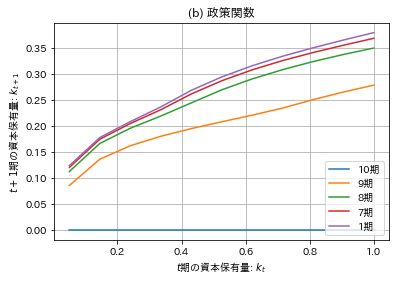

In [5]:
fig, ax = plt.subplots()
ax.plot(m.kgrid,pfcn[:,m.TT-1],label="10期")
ax.plot(m.kgrid,pfcn[:,8],label="9期")
ax.plot(m.kgrid,pfcn[:,7],label="8期")
ax.plot(m.kgrid,pfcn[:,6],label="7期")
ax.plot(m.kgrid,pfcn[:,0],label="1期")
ax.set(xlabel=r"$t$期の資本保有量: $k_{t}$", ylabel=r"$t+1$期の資本保有量: $k_{t+1}$",title="(b) 政策関数")
ax.grid()
ax.legend(loc="lower right")
plt.show()

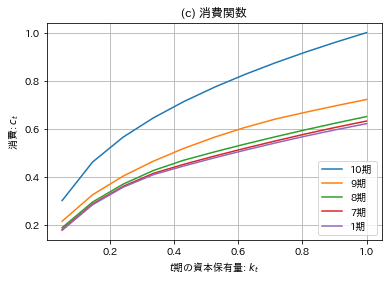

In [6]:
fig, ax = plt.subplots()
ax.plot(m.kgrid,cfcn[:,m.TT-1],label="10期")
ax.plot(m.kgrid,cfcn[:,8],label="9期")
ax.plot(m.kgrid,cfcn[:,7],label="8期")
ax.plot(m.kgrid,cfcn[:,6],label="7期")
ax.plot(m.kgrid,cfcn[:,0],label="1期")
ax.set(xlabel=r"$t$期の資本保有量: $k_{t}$", ylabel=r"消費: $c_{t}$",title="(c) 消費関数")
ax.grid()
ax.legend(loc="lower right")
plt.show()

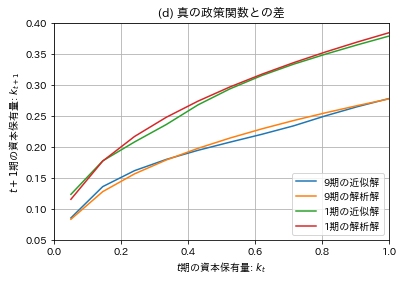

In [7]:
fig, ax = plt.subplots()
ax.plot(m.kgrid,pfcn[:,8],label="9期の近似解")
ax.plot(m.kgrid,p_true[:,8],label="9期の解析解")
ax.plot(m.kgrid,pfcn[:,0],label="1期の近似解")
ax.plot(m.kgrid,p_true[:,0],label="1期の解析解")
ax.set(xlabel=r"$t$期の資本保有量: $k_{t}$", ylabel=r"$t+1$期の資本保有量: $k_{t+1}$",title="(d) 真の政策関数との差",xlim=(0,1),ylim=(0.05,0.4))
ax.grid()
ax.legend(loc="lower right")
plt.show()